In [1]:
#!/usr/bin/python -tt 
# -*- coding: utf-8-sig -*-
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import codecs
import cv2
import keras
from keras.layers import Input,Dense, Dropout, Flatten,Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD,RMSprop,Adam
from keras import backend as K
from keras.models import model_from_json
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
import itertools
import errno
import time
#from sklearn.model_selection import KFold
#from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split
from os.path import join
import random
import tensorflow as tf
import json as simplejson
import datetime as dt          
#from difflib import SequenceMatcher
import Levenshtein
from keras.callbacks import CSVLogger
from contextlib import redirect_stdout
from keras.preprocessing import image
from collections import Counter
from keras import regularizers

In [8]:
def generate_code(path):
    files=glob.glob(path + '*.gt.txt')
    print('A number of files=',len(files))
    letters = ''
    lens = []
    for fname in files:
        f1 = codecs.open(fname, "r", "utf-8")
        transcript = f1.read()
        lens.append(len(transcript))
        letters += transcript
    max_len=max(Counter(lens).keys())
    print('Maximum transcript length=', max_len)
    return Counter(letters),max_len

def labels2text(labels,letters):
    txt=''.join(list(map(lambda x: letters[int(x)], labels)))
    return txt

def text2labels(text,letters):
    return list(map(lambda x: letters.index(x), text))

def is_valid_str(s,letters):
    for ch in s:
        if not ch in letters:
            return False
    return True

def loadDataset(path,file):
    with codecs.open(path+file,'r','utf-8-sig') as f:
        rlines=f.readlines()
    data=[]
    label=[]
    for i,lines in enumerate(rlines):
        line=lines.rstrip('\n')
        txt=line.split('|')
        data.append(txt[0]+'.png')
        label.append(txt[1])
    return data, label

class TextImageGen:

    def __init__(self,
                 dirpath,
                 letters,
                 X,
                 Y,
                 img_w,
                 img_h,
                 batch_size, 
                 pool_size,
                 max_text_len):
        self.letters = letters
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.downsample_factor = pool_size ** 2
        self.samples = []
        img_dirpath = dirpath
        img_filepath=X
        transcription=Y

        if len(transcription)==len(img_filepath):
            for i in range(len(img_filepath)):
                if is_valid_str(transcription[i],self.letters):
                    self.samples.append([join(img_dirpath,img_filepath[i]), transcription[i]])
                else:
                    print('Image file %s does not match to transcription [%s].' % (img_filepath[i],transcription[i]))
                    
        self.max_text_len=max_text_len
        self.n = len(self.samples)
        self.cur_index = 0

    def build_data(self,train=True):
        self.imgs = []
#        self.augs = []
        self.texts = []
        self.file_name=[]
        for i, (img_filepath, text) in enumerate(self.samples):
            img = cv2.imread(img_filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img.astype(np.float32)
            img /= 255.0
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            tmp=np.expand_dims(img.T, -1)
            self.imgs.append(img)
            num_aug=1
            # generate augmenation
            if (train):
                img_t=image.random_rotation(tmp, 30, row_axis=1, col_axis=2)
                self.imgs.append(np.expand_dims(img_t.T, -1))
                img_t=image.random_shear(tmp, 0.2, row_axis=1, col_axis=2)
                self.imgs.append(np.expand_dims(img_t.T, -1))
                img_t=image.random_shift(tmp, 0.2, 0.2, row_axis=1, col_axis=2)
                self.imgs.append(np.expand_dims(img_t.T, -1))
                img_t=image.random_zoom(tmp, (0.8,0.8), row_axis=1, col_axis=2)
                self.imgs.append(np.expand_dims(img_t.T, -1))
                num_aug=5
            for j in range(num_aug):
                self.texts.append(text) 
                self.file_name.append(img_filepath)
                    
        self.n_aug=len(self.imgs)
        self.indexes = random.sample(list(range(self.n_aug)),self.n_aug)
    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n_aug:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.indexes[self.cur_index]
    
    def next_batch(self):
        while True:
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.zeros([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - 2)
            label_length = np.zeros((self.batch_size, 1))
            file_name = []
                                   
            for i in range(self.batch_size):
                idx = self.next_sample()
                if idx>=self.n_aug:
                    print(idx)
                    break
                X_data[i] = np.reshape(self.imgs[idx].T,(self.img_w,self.img_h,1))
                file_name.append(self.file_name[idx])
                lab=text2labels(self.texts[idx],letters)
                for k,l in enumerate(lab):
                    Y_data[i][k]=l
                label_length[i] = len(self.texts[idx])
                
            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length,
                'file_name': file_name
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


def train(path,newpath,letters,x_train,x_valid,img_h,img_w,train_type,epochs,
          rnn_size,batch_size,max_len,num_classes, pool_size, load=False):

    # Network parameters
    conv_filters1 = 16
    conv_filters2 = 16
    kernel_size = (3, 3)
    time_dense_size = 32
#    stop_here = EarlyStopping(monitor='val_loss',patience=5,verbose=0)
    
    input_shape = (img_w, img_h, 1)
    
    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    inner = Conv2D(conv_filters1, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    # adding dropout
    inner = Dropout(0.2)(inner)
    inner = Conv2D(conv_filters2, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)
    # adding dropout
    inner = Dropout(0.2)(inner)

    conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters2)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    # cuts down input size going into RNN:
    # adding weight_decay
    weight_decay=0.001
    inner = Dense(time_dense_size, activation=act, name='dense1', 
                  kernel_regularizer=regularizers.l2(weight_decay))(inner)
#                  activity_regularizer=regularizers.l1(weight_decay))(inner)

    # Two layers of bidirecitonal GRUs
    # GRU seems to work as well, if not better than LSTM:
    if train_type=='GRU':
        gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
        gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True,dropout=0.2,recurrent_dropout=0.2, 
                     kernel_initializer='he_normal', name='gru1_b')(inner)
        gru1_merged = add([gru_1, gru_1b])
        gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
        # adding dropout
        gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True,dropout=0.2,recurrent_dropout=0.2, 
                     kernel_initializer='he_normal', name='gru2_b')(gru1_merged)
        # transforms RNN output to character activations:
        # adding weight_decay
        inner = Dense(num_classes, kernel_initializer='he_normal',name='dense2', 
                  kernel_regularizer=regularizers.l2(weight_decay))(concatenate([gru_2, gru_2b]))
#                  activity_regularizer=regularizers.l1(weight_decay))(concatenate([gru_2, gru_2b]))

    else:
        lstm_1 = LSTM(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='lstm1')(inner)
        lstm_1b = LSTM(rnn_size, return_sequences=True, go_backwards=True, dropout=0.2,recurrent_dropout=0.2,
                       kernel_initializer='he_normal', name='lstm1_b')(inner)
        lstm1_merged = add([lstm_1, lstm_1b])
        lstm_2 = LSTM(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='lstm2')(lstm1_merged)
        # adding dropout
        lstm_2b = LSTM(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='lstm2_b')(lstm1_merged)

        # transforms RNN output to character activations:
        # adding weight_decay
        inner = Dense(num_classes, kernel_initializer='he_normal',name='dense2', 
                  kernel_regularizer=regularizers.l2(weight_decay),
                  activity_regularizer=regularizers.l1(weight_decay))(concatenate([lstm_2, lstm_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)

    with open(newpath+'model_summary.txt', 'w') as f:
        with redirect_stdout(f):
            Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[x_train.max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    #opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-6) 
    #opt=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    if load:
        # load weights into new model
        print("Loaded model from disk")
        model = load_model('data/modelCnnLSTM.h5', compile=False)
    else:
        model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
#    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt,metrics=['acc'])
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt)
    if not load:
        # captures output of softmax so we can decode the output during visualization
        test_func = K.function([input_data], [y_pred])
        csv_logger = CSVLogger(newpath+'history.log',append=True, separator=',') 
        steps_per_epoch=x_train.n_aug//batch_size
        valid_steps=x_valid.n_aug//batch_size
        history=model.fit_generator(generator=x_train.next_batch(), steps_per_epoch=steps_per_epoch,epochs=epochs,
                            validation_data=x_valid.next_batch(),validation_steps=valid_steps,
                            callbacks=[csv_logger])
#                            callbacks=[stop_here, csv_logger])
    else:
        return model

    return model, history

def evaluate_model(model, x_test, letters,batch_size,max_len,num_classes):
    print('Evaluating model...')

    steps_per_epoch=np.ceil(x_test.n_aug / batch_size)
    score = model.evaluate_generator(generator=x_test.next_batch(), steps=steps_per_epoch, verbose=1)
    print("Loss: ", score)
    print('Predict model')
    y_pred = model.predict_generator(generator=x_test.next_batch(), steps=steps_per_epoch, verbose=1)

    return score, y_pred

def generateEvaluationGraph(history,i):
    # Loss curves
    f,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))    
    f.suptitle('Fold: '+str(i),fontsize=18)
    ax1.plot(history.history['loss'],'r',linewidth=3.0)
    ax1.plot(history.history['val_loss'],'b',linewidth=3.0)
    ax1.legend(['Training loss', 'Validation Loss'],fontsize=16)
    ax1.set_xlabel('Epochs ',fontsize=16)
    ax1.set_ylabel('Loss',fontsize=16)
    ax1.set_title('Loss Curves',fontsize=16)
 
    # Accuracy Curves
 #   ax2.plot(history.history['acc'],'r',linewidth=3.0)
 #   ax2.plot(history.history['val_acc'],'b',linewidth=3.0)
 #   ax2.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16)
 #   ax2.set_xlabel('Epochs ',fontsize=16)
 #   ax2.set_ylabel('Accuracy',fontsize=16)
 #   ax2.set_title('Accuracy Curves',fontsize=16)
    return f
        
def decode_batch(out,letters):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(letters)-1:
                outstr += letters[c]
        ret.append(outstr)
    return ret

def writeResult(finame,xx,model,letters,sess):
    net_inp = model.get_layer(name='the_input').input
    net_out = model.get_layer(name='softmax').output    
    cnt=0
    tot=0
    k=1
    r=0
    with codecs.open(finame+'_result.txt','w','utf-8-sig') as fi:
        str1='File Prediction'
        fi.write(str1+'\n')
        
        for inp_value, _ in xx.next_batch():
            bs = inp_value['the_input'].shape[0]
            X_data = inp_value['the_input']
            net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
            pred = decode_batch(net_out_value,letters)
            labels = inp_value['the_labels']
            label_length = inp_value['label_length']
            file_name = inp_value['file_name']
            texts = []
            for label in labels:
                text = ''.join(list(map(lambda x: letters[int(x)], label)))
                texts.append(text)

            for i in range(bs):
                tot +=label_length[i]
                str1='Sample No.:%d, file_name: %s'% (k,file_name[i])
                fi.write(str1+'\n')
                fi.write('Predicted: %s\nTrue: %s\n' % (pred[i], texts[i]))
                c=label_length[i]-Levenshtein.distance(texts[i].rstrip(),pred[i].rstrip())
                cnt+=c
                str1='#Corrected characters is %d from %d (%.4f%%)'%(c,label_length[i],c/label_length[i]*100)
                fi.write(str1+'\n')
                s=Levenshtein.ratio(texts[i].rstrip(),pred[i].rstrip())
                r += s
                str1='Match sequence ratio is %.4f%%' % (s*100)
                fi.write(str1+'\n')
                k=k+1
            if k>xx.n_aug:
                break
        str1='\nTotal corrected characters is %d from %d (%.4f%%)'%(cnt,tot,cnt/tot*100)
        print(str1)
        fi.write(str1+'\n')
        str1='Match sequence average ratio is %.4f%%' % ((r/(k-1)*100))
        print(str1)
        fi.write(str1+'\n')

def process(path,letters,max_len,x_train,x_test, pool_size,batch_size, 
           img_h,img_w,train_type='GRU',rnn_size=128):
        ### start session
    session_config = K.tf.ConfigProto(log_device_placement=False, allow_soft_placement=True)    
    # please do not use the totality of the GPU memory
    session_config.gpu_options.per_process_gpu_memory_fraction = 0.90

    sess = tf.Session()
    K.set_session(sess)

    # in 1 epoch = number of training examples/batch_size
    epochs = 100
    print('epochs=',epochs)
 
    start=time.time()
    done = time.time()
    elapsed = done - start
    print(time.strftime("ETA of load image files=%H:%M:%S", time.gmtime(elapsed)))
    start_all=time.time()

    newpath = path+'augment/resultCNN{}_h{}_b{}__{}/'.format(train_type,rnn_size,batch_size,
                dt.datetime.now().strftime('%Y%m%d_%H')) 
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    
    model,history = train(path,newpath,letters,x_train,x_test,img_h,img_w,
                          train_type,epochs,rnn_size,batch_size,
                          max_len,num_classes,pool_size,load=False)

    done_all = time.time()
    elapsed = done_all - start_all
    print(time.strftime("ETA of all rounds=%H:%M:%S", time.gmtime(elapsed)))

    # serialize weights to HDF5
    model.save(newpath+'model.h5')
    print("Save model to disk...")

    fig=generateEvaluationGraph(history,1)
    try:
        with PdfPages(newpath+'plot.pdf') as pdf:
            pdf.savefig(fig)
    except ValueError:
        print('error save plot.pdf')

    writeResult(newpath+'train',x_train,model,letters,sess)
    writeResult(newpath+'test',x_test,model,letters,sess)

#    K.clear_session() # ถ้าไม่ต้องการแสดงผลลัพธ์ test ทางหน้าจอ ให้เอา comment ออก


In [3]:
### main
path='d:/hwocr/data/'
print('Loading dataset...')
Xdata_train,Ydata_train=loadDataset(path,'trainData80.txt')
print('A number of training samples is ',len(Xdata_train))
Xdata_test, Ydata_test =loadDataset(path, 'testData20.txt')
print('A number of test/valid samples is ',len(Xdata_test))
print('Generating code for character set...') 
c_train,max_len=generate_code(path)

letters_train = set(c_train.keys())
letters=sorted(list(letters_train))
print('Letters:', ' '.join(letters))

print(letters)
num_classes=len(letters)

print('A number of class=',num_classes)

# Generate image and label
print('Generating images and labels...')
pool_size=2
img_w=640
img_h=128
batch_size=32
print('batch_size=',batch_size)
x_train = TextImageGen(path,letters,Xdata_train,Ydata_train,img_w, img_h, batch_size, pool_size,max_len)
x_train.build_data(train=True)
print('A number of training samples with augmentation=',x_train.n_aug)
x_test = TextImageGen(path,letters,Xdata_test,Ydata_test, img_w, img_h, batch_size, pool_size,max_len)
x_test.build_data(train=False)
print('A number of test/valid samples with augmentation=',x_test.n_aug)

Loading dataset...
A number of training samples is  2756
A number of test/valid samples is  690
Generating code for character set...
A number of files= 3446
Maximum transcript length= 62
Letters:   " ( ) + , - . / _ x ก ข ฃ ค ฆ ง จ ฉ ช ซ ฌ ญ ฎ ฏ ฐ ฑ ฒ ณ ด ต ถ ท ธ น บ ป ผ ฝ พ ฟ ภ ม ย ร ฤ ล ฦ ว ศ ษ ส ห ฬ อ ฮ ฯ ะ ั า ำ ิ ี ึ ื ุ ู เ แ โ ใ ไ ๅ ๆ ็ ่ ้ ๊ ๋ ์ ๐ ๑ ๒ ๓ ๔ ๕ ๖ ๗ ๘ ๙ ๚ – ﻿
[' ', '"', '(', ')', '+', ',', '-', '.', '/', '_', 'x', 'ก', 'ข', 'ฃ', 'ค', 'ฆ', 'ง', 'จ', 'ฉ', 'ช', 'ซ', 'ฌ', 'ญ', 'ฎ', 'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท', 'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ฤ', 'ล', 'ฦ', 'ว', 'ศ', 'ษ', 'ส', 'ห', 'ฬ', 'อ', 'ฮ', 'ฯ', 'ะ', 'ั', 'า', 'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'เ', 'แ', 'โ', 'ใ', 'ไ', 'ๅ', 'ๆ', '็', '่', '้', '๊', '๋', '์', '๐', '๑', '๒', '๓', '๔', '๕', '๖', '๗', '๘', '๙', '๚', '–', '\ufeff']
A number of class= 93
Generating images and labels...
batch_size= 32
A number of training samples with augmentation= 13780
A number of test/valid s

epochs= 100
ETA of load image files=00:00:00
Epoch 1/100
430/430 [==============================] - 229s 532ms/step - loss: 66.1199 - val_loss: 58.2320
Epoch 2/100
430/430 [==============================] - 226s 524ms/step - loss: 57.6107 - val_loss: 53.6666
Epoch 3/100
430/430 [==============================] - 226s 525ms/step - loss: 51.7019 - val_loss: 45.8675
Epoch 4/100
430/430 [==============================] - 226s 524ms/step - loss: 44.6198 - val_loss: 38.4207
Epoch 5/100
430/430 [==============================] - 225s 524ms/step - loss: 36.6927 - val_loss: 29.9873
Epoch 6/100
430/430 [==============================] - 225s 524ms/step - loss: 27.2926 - val_loss: 21.5219
Epoch 7/100
430/430 [==============================] - 226s 525ms/step - loss: 20.2715 - val_loss: 17.2502
Epoch 8/100
430/430 [==============================] - 226s 526ms/step - loss: 15.8800 - val_loss: 13.9801
Epoch 9/100
430/430 [==============================] - 226s 525ms/step - loss: 13.2685 - val_loss: 

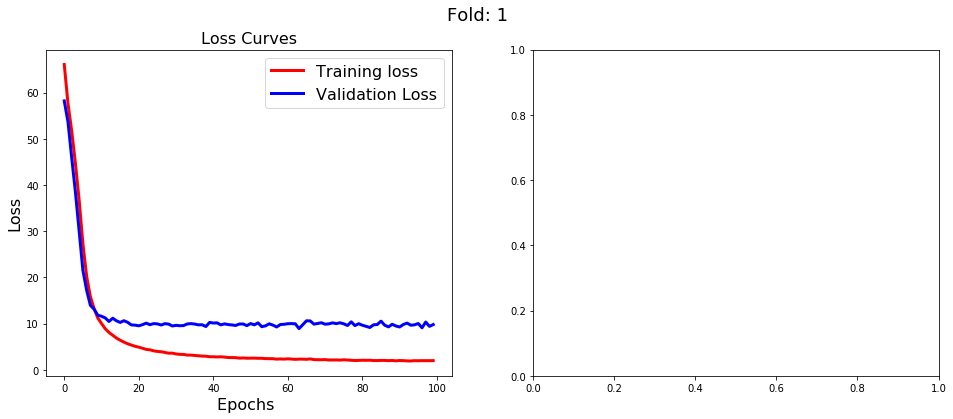

In [9]:
process(path,letters,max_len,x_train,x_test, pool_size,batch_size, 
       img_h,img_w,train_type='GRU',rnn_size=128)

In [ ]:
# code for checking dataset

for inp, out in x_test.next_batch():
    print('Text generator output (data which will be fed into the neutral network):')
    for i in range(batch_size):
        print('\n1) the_input (image)')
        img = inp['the_input'][i, :, :, 0]
        plt.imshow(img.T, cmap='gray')
        plt.show()
        print('2) the_labels : %s is encoded as %s' % 
          (labels2text(inp['the_labels'][i],letters), list(map(int, inp['the_labels'][i]))))
        print('3) input_length (width of image that is fed to the loss function): %d == %d / 4 - 2' % 
          (inp['input_length'][i], x_test.img_w))
        print('4) label_length (length of sentecnes): %d' % inp['label_length'][i])
        print('5) file_name: %s' % inp['file_name'][i])
    break

epochs= 100
ETA of load image files=00:00:00
Epoch 1/100
861/861 [==============================] - 444s 516ms/step - loss: 68.4943 - acc: 0.0000e+00 - val_loss: 58.8513 - val_acc: 0.0000e+00
Epoch 2/100
861/861 [==============================] - 442s 513ms/step - loss: 58.0615 - acc: 0.0000e+00 - val_loss: 52.4010 - val_acc: 0.0000e+00
Epoch 3/100
861/861 [==============================] - 441s 512ms/step - loss: 50.5280 - acc: 0.0000e+00 - val_loss: 44.6146 - val_acc: 0.0000e+00
Epoch 4/100
861/861 [==============================] - 442s 514ms/step - loss: 42.6745 - acc: 0.0000e+00 - val_loss: 36.5424 - val_acc: 0.0000e+00
Epoch 5/100
861/861 [==============================] - 442s 513ms/step - loss: 33.7271 - acc: 0.0000e+00 - val_loss: 28.7368 - val_acc: 0.0000e+00
Epoch 6/100
861/861 [==============================] - 441s 512ms/step - loss: 24.9864 - acc: 0.0000e+00 - val_loss: 22.1590 - val_acc: 0.0000e+00
Epoch 7/100
861/861 [==============================] - 442s 513ms/step - 

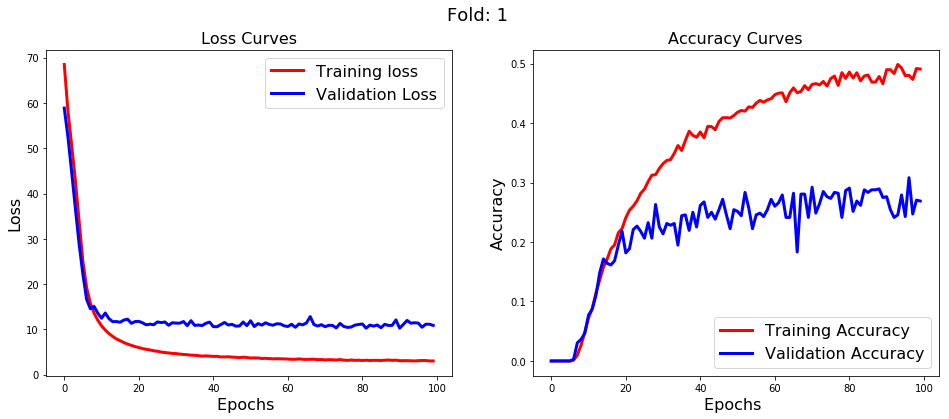

In [4]:
process(path,letters,max_len,x_train,x_test, pool_size,batch_size, 
       img_h,img_w,train_type='GRU',rnn_size=128)

epochs= 100
ETA of load image files=00:00:00
Epoch 1/100
1722/1722 [==============================] - 870s 505ms/step - loss: 60.1227 - acc: 0.0000e+00 - val_loss: 47.6187 - val_acc: 0.0000e+00
Epoch 2/100
1722/1722 [==============================] - 869s 505ms/step - loss: 39.2717 - acc: 0.0000e+00 - val_loss: 24.4560 - val_acc: 0.0000e+00
Epoch 3/100
1722/1722 [==============================] - 869s 504ms/step - loss: 21.1226 - acc: 2.9036e-04 - val_loss: 16.0932 - val_acc: 0.0015
Epoch 4/100
1722/1722 [==============================] - 869s 505ms/step - loss: 14.6675 - acc: 0.0108 - val_loss: 12.3874 - val_acc: 0.0116
Epoch 5/100
1722/1722 [==============================] - 868s 504ms/step - loss: 11.7010 - acc: 0.0383 - val_loss: 11.8186 - val_acc: 0.0843
Epoch 6/100
1722/1722 [==============================] - 869s 505ms/step - loss: 10.0383 - acc: 0.0719 - val_loss: 11.5953 - val_acc: 0.0988
Epoch 7/100
1722/1722 [==============================] - 870s 505ms/step - loss: 8.9336 -

Epoch 59/100
1722/1722 [==============================] - 871s 506ms/step - loss: 4.1474 - acc: 0.3359 - val_loss: 9.9770 - val_acc: 0.2224
Epoch 60/100
1722/1722 [==============================] - 871s 506ms/step - loss: 4.0260 - acc: 0.3441 - val_loss: 10.6089 - val_acc: 0.2500
Epoch 61/100
1722/1722 [==============================] - 873s 507ms/step - loss: 4.0472 - acc: 0.3396 - val_loss: 9.7977 - val_acc: 0.2674
Epoch 62/100
1722/1722 [==============================] - 870s 506ms/step - loss: 3.9933 - acc: 0.3558 - val_loss: 9.5814 - val_acc: 0.2660
Epoch 63/100
1722/1722 [==============================] - 871s 506ms/step - loss: 4.0476 - acc: 0.3455 - val_loss: 10.1738 - val_acc: 0.2500
Epoch 64/100
1722/1722 [==============================] - 870s 505ms/step - loss: 3.9817 - acc: 0.3532 - val_loss: 10.7479 - val_acc: 0.2253
Epoch 65/100
1722/1722 [==============================] - 871s 506ms/step - loss: 4.3237 - acc: 0.3135 - val_loss: 10.4066 - val_acc: 0.2326
Epoch 66/100
172

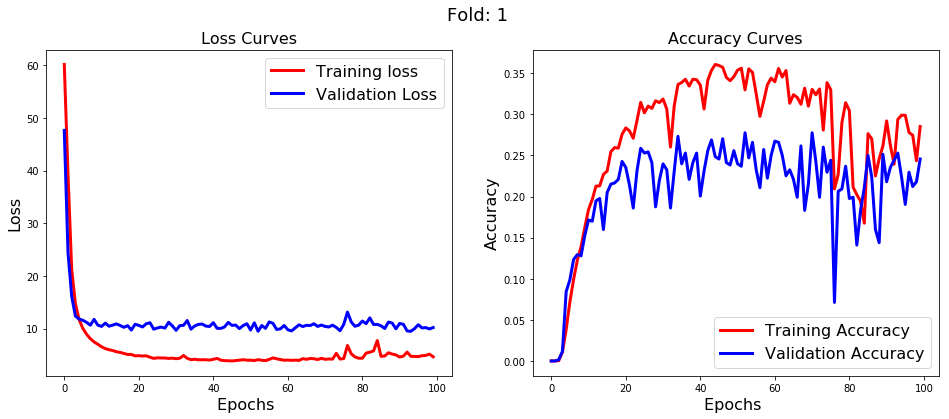

In [4]:
process(path,letters,max_len,x_train,x_test, pool_size,batch_size, 
       img_h,img_w,train_type='GRU',rnn_size=128)

epochs= 100
ETA of load image files=00:00:00
Epoch 1/100
430/430 [==============================] - 229s 532ms/step - loss: 69.3720 - acc: 0.0000e+00 - val_loss: 60.5910 - val_acc: 0.0000e+00
Epoch 2/100
430/430 [==============================] - 226s 525ms/step - loss: 60.1941 - acc: 0.0000e+00 - val_loss: 52.8738 - val_acc: 0.0000e+00
Epoch 3/100
430/430 [==============================] - 226s 525ms/step - loss: 52.7600 - acc: 0.0000e+00 - val_loss: 47.2583 - val_acc: 0.0000e+00
Epoch 4/100
430/430 [==============================] - 226s 525ms/step - loss: 46.1188 - acc: 0.0000e+00 - val_loss: 40.2079 - val_acc: 0.0000e+00
Epoch 5/100
430/430 [==============================] - 226s 525ms/step - loss: 38.9699 - acc: 0.0000e+00 - val_loss: 33.4513 - val_acc: 0.0000e+00
Epoch 6/100
430/430 [==============================] - 226s 526ms/step - loss: 31.1631 - acc: 0.0000e+00 - val_loss: 26.0544 - val_acc: 0.0000e+00
Epoch 7/100
430/430 [==============================] - 226s 526ms/step - 

430/430 [==============================] - 227s 528ms/step - loss: 5.2108 - acc: 0.2932 - val_loss: 12.1847 - val_acc: 0.2024
Epoch 60/100
430/430 [==============================] - 227s 528ms/step - loss: 5.1337 - acc: 0.3018 - val_loss: 11.5940 - val_acc: 0.1771
Epoch 61/100
430/430 [==============================] - 227s 528ms/step - loss: 5.0236 - acc: 0.3086 - val_loss: 12.0643 - val_acc: 0.1905
Epoch 62/100
430/430 [==============================] - 227s 528ms/step - loss: 5.0346 - acc: 0.3060 - val_loss: 11.7048 - val_acc: 0.2083
Epoch 63/100
430/430 [==============================] - 227s 528ms/step - loss: 5.0659 - acc: 0.3076 - val_loss: 12.4517 - val_acc: 0.2217
Epoch 64/100
430/430 [==============================] - 227s 528ms/step - loss: 5.0050 - acc: 0.3161 - val_loss: 12.2005 - val_acc: 0.2188
Epoch 65/100
430/430 [==============================] - 227s 528ms/step - loss: 4.8968 - acc: 0.3126 - val_loss: 11.7254 - val_acc: 0.2188
Epoch 66/100
430/430 [==================

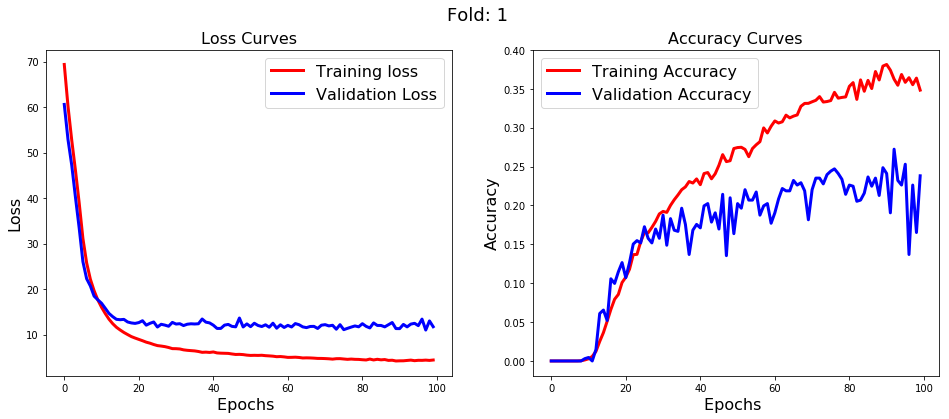

In [4]:
process(path,letters,max_len,x_train,x_test, pool_size,batch_size, 
       img_h,img_w,train_type='GRU',rnn_size=128)

In [ ]:
net_inp = model.get_layer(name='the_input').input
net_out = model.get_layer(name='softmax').output

for inp_value, _ in x_test.next_batch():
    bs = inp_value['the_input'].shape[0]
    X_data = inp_value['the_input']
    net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
    pred_texts = decode_batch(net_out_value,letters)
    labels = inp_value['the_labels']
    texts = []
    for label in labels:
        text = ''.join(list(map(lambda x: letters[int(x)], label)))
        texts.append(text)
    
    for i in range(bs):
        fig = plt.figure(figsize=(10, 10))
        outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.1)
        ax1 = plt.Subplot(fig, outer[0])
        fig.add_subplot(ax1)
        ax2 = plt.Subplot(fig, outer[1])
        fig.add_subplot(ax2)
        print('Predicted: %s\nTrue: %s' % (pred_texts[i], texts[i]))
        img = X_data[i][:, :, 0].T
        ax1.set_title('Input img')
        ax1.imshow(img, cmap='gray')
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_title('Activations')
        ax2.imshow(net_out_value[i].T, cmap='binary', interpolation='nearest')
        ax2.set_yticks(list(range(len(letters) + 1)))
        ax2.set_yticklabels(letters + ['blank'])
        ax2.grid(False)
        for h in np.arange(-0.5, len(letters) + 1 + 0.5, 1):
            ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)
        
        #ax.axvline(x, linestyle='--', color='k')
        plt.show()
    break